Обучить генератор создавать точки, которые будут лежать на графике функции 𝑦=𝑥*sin(𝑥)−10𝑥

При выполнении данного задания структура GAN остается той же, но вам нужно:
- Сгенерировать настоящие данные
- Изменить архитектуру дискриминатора и генератора
- Построить графики

In [85]:
import math
import torch.nn as nn
import torch
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from torch.optim import Adam
from tqdm import tqdm

In [86]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [87]:
torch.manual_seed(111)

# Подготовка данных для обучения GAN

In [88]:
train_data_length = 1024
train_data = torch.zeros((train_data_length, 2))
# интервал (0, 2π)
train_data[:, 0] = 2 * math.pi * torch.rand(train_data_length)
# 𝑦=𝑥*sin(𝑥)−10𝑥
train_data[:, 1] = train_data[:, 0] * torch.sin(train_data[:, 0]) - 10 * train_data[:, 0]
# 𝑦=𝑥*sin(𝑥)
# train_data[:, 1] = train_data[:, 0] * torch.sin(train_data[:, 0])
train_labels = torch.zeros(train_data_length)
train_set = [(train_data[i], train_labels[i]) for i in range(train_data_length)]

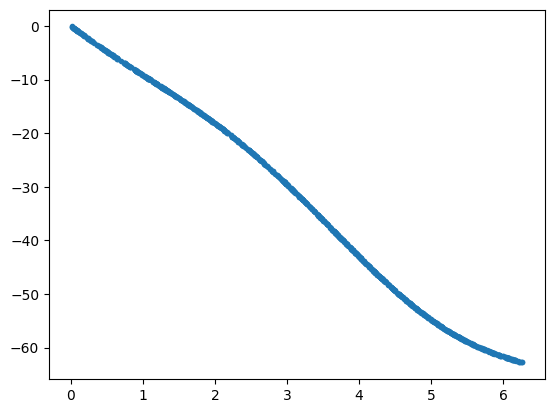

In [89]:
plt.plot(train_data[:, 0], train_data[:, 1], ".");

In [90]:
batch_size = 32
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

# Реализация дискриминатора GAN

In [91]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid())

    def forward(self, x):
        output = self.model(x)
        return output

In [92]:
discriminator = Discriminator()

# Реализация генератора GAN

Выходные данные будут состоять из двух элементов, имеющих значение в диапазоне от −∞ до +∞, которое будет представлять (x̃1, x̃2). То есть исходно мы не накладываем на генератор никакие ограничения – он должен «всему научиться сам».

In [93]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 2))

    def forward(self, x):
        output = self.model(x)
        return output

In [94]:
generator = Generator()

# Обучение моделей GAN

In [95]:
lr = 1e-3
num_epochs = 250
loss_function = nn.BCELoss()

In [96]:
optimizer_discriminator = Adam(discriminator.parameters(), lr=lr)
optimizer_generator = Adam(generator.parameters(), lr=lr)

In [97]:
for epoch in tqdm(range(num_epochs)):
    for n, (real_samples, _) in enumerate(train_loader):
        # Данные для обучения дискриминатора
        real_samples_labels = torch.ones((batch_size, 1))
        latent_space_samples = torch.randn((batch_size, 2))
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1))
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels))

        # Обучение дискриминатора
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Данные для обучения генератора
        latent_space_samples = torch.randn((batch_size, 2))

        # Обучение генератора
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels)
        loss_generator.backward()
        optimizer_generator.step()

        # Выводим значения функций потерь
        if epoch % 10 == 0 and n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}\t" \
                  f"Epoch: {epoch} Loss G.: {loss_generator}")

  1%|          | 2/250 [00:00<00:32,  7.68it/s]

Epoch: 0 Loss D.: 0.09720272570848465	Epoch: 0 Loss G.: 2.4834115505218506


  5%|▍         | 12/250 [00:02<00:41,  5.71it/s]

Epoch: 10 Loss D.: 0.6467182040214539	Epoch: 10 Loss G.: 1.06496262550354


  9%|▉         | 22/250 [00:03<00:30,  7.44it/s]

Epoch: 20 Loss D.: 0.650469958782196	Epoch: 20 Loss G.: 0.7984982132911682


 13%|█▎        | 32/250 [00:04<00:29,  7.33it/s]

Epoch: 30 Loss D.: 0.7031257748603821	Epoch: 30 Loss G.: 0.7614925503730774


 17%|█▋        | 42/250 [00:06<00:28,  7.17it/s]

Epoch: 40 Loss D.: 0.6931985020637512	Epoch: 40 Loss G.: 0.7168501615524292


 21%|██        | 52/250 [00:07<00:27,  7.22it/s]

Epoch: 50 Loss D.: 0.6979274749755859	Epoch: 50 Loss G.: 0.6882537007331848


 25%|██▍       | 62/250 [00:09<00:26,  7.21it/s]

Epoch: 60 Loss D.: 0.6933474540710449	Epoch: 60 Loss G.: 0.672038197517395


 29%|██▉       | 72/250 [00:10<00:24,  7.27it/s]

Epoch: 70 Loss D.: 0.6973812580108643	Epoch: 70 Loss G.: 0.6916016340255737


 33%|███▎      | 82/250 [00:11<00:23,  7.17it/s]

Epoch: 80 Loss D.: 0.6956686973571777	Epoch: 80 Loss G.: 0.6853386163711548


 36%|███▋      | 91/250 [00:13<00:27,  5.72it/s]

Epoch: 90 Loss D.: 0.6910806894302368	Epoch: 90 Loss G.: 0.6989307999610901


 41%|████      | 102/250 [00:15<00:24,  6.16it/s]

Epoch: 100 Loss D.: 0.6933480501174927	Epoch: 100 Loss G.: 0.6916912794113159


 45%|████▍     | 112/250 [00:16<00:19,  7.23it/s]

Epoch: 110 Loss D.: 0.6897828578948975	Epoch: 110 Loss G.: 0.6894490718841553


 49%|████▉     | 122/250 [00:18<00:17,  7.20it/s]

Epoch: 120 Loss D.: 0.6942387223243713	Epoch: 120 Loss G.: 0.6905614733695984


 53%|█████▎    | 132/250 [00:19<00:16,  7.34it/s]

Epoch: 130 Loss D.: 0.6936190724372864	Epoch: 130 Loss G.: 0.692354679107666


 57%|█████▋    | 142/250 [00:20<00:15,  7.06it/s]

Epoch: 140 Loss D.: 0.6926597356796265	Epoch: 140 Loss G.: 0.6917754411697388


 61%|██████    | 152/250 [00:22<00:13,  7.10it/s]

Epoch: 150 Loss D.: 0.693835437297821	Epoch: 150 Loss G.: 0.6925392150878906


 65%|██████▍   | 162/250 [00:23<00:12,  7.33it/s]

Epoch: 160 Loss D.: 0.692737340927124	Epoch: 160 Loss G.: 0.6942226886749268


 69%|██████▉   | 172/250 [00:25<00:12,  6.49it/s]

Epoch: 170 Loss D.: 0.6949237585067749	Epoch: 170 Loss G.: 0.7052012085914612


 73%|███████▎  | 182/250 [00:27<00:13,  4.99it/s]

Epoch: 180 Loss D.: 0.6949957013130188	Epoch: 180 Loss G.: 0.7170943021774292


 77%|███████▋  | 192/250 [00:28<00:08,  7.19it/s]

Epoch: 190 Loss D.: 0.6927797794342041	Epoch: 190 Loss G.: 0.6940886378288269


 81%|████████  | 202/250 [00:29<00:06,  7.30it/s]

Epoch: 200 Loss D.: 0.693713366985321	Epoch: 200 Loss G.: 0.6936050057411194


 85%|████████▍ | 212/250 [00:31<00:05,  7.06it/s]

Epoch: 210 Loss D.: 0.7105892896652222	Epoch: 210 Loss G.: 0.6968587636947632


 89%|████████▉ | 222/250 [00:32<00:03,  7.03it/s]

Epoch: 220 Loss D.: 0.6935346722602844	Epoch: 220 Loss G.: 0.6914927363395691


 93%|█████████▎| 232/250 [00:34<00:02,  6.92it/s]

Epoch: 230 Loss D.: 0.6921361684799194	Epoch: 230 Loss G.: 0.6111913919448853


 97%|█████████▋| 242/250 [00:35<00:01,  6.97it/s]

Epoch: 240 Loss D.: 0.6527582406997681	Epoch: 240 Loss G.: 0.5887589454650879


100%|██████████| 250/250 [00:36<00:00,  6.80it/s]


# Проверка образцов, сгенерированных GAN

In [100]:
latent_space_samples = torch.randn(512, 2)
generated_samples = generator(latent_space_samples)

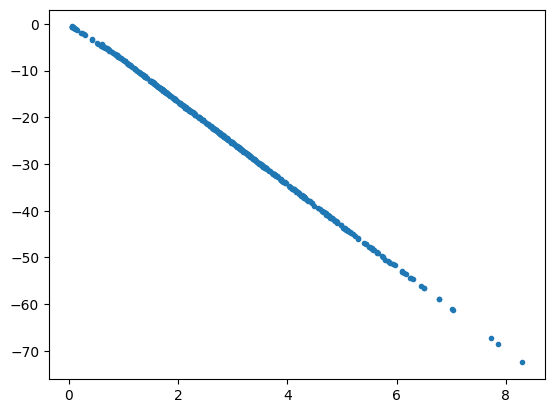

In [101]:
generated_samples = generated_samples.detach()
plt.plot(generated_samples[:, 0], generated_samples[:, 1], ".");